In [2]:
import pandas as pd
train_data = pd.read_csv('/Users/wangluya/PycharmProjects/datasets/digit_recognizer/train.csv')
test_data = pd.read_csv('/Users/wangluya/PycharmProjects/datasets/digit_recognizer/test.csv')
print(f'训练数据shape: {train_data.shape}')
print(f'测试数据shape: {test_data.shape}')

# 可以看到测试集合比训练集少一维，因为训练数据的第0列是类标签(0-9)， 
# 手写体数据实际上是一张28*28的矩阵，这里把这个矩阵平铺开了变成784维度的数据

训练数据shape: (42000, 785)
测试数据shape: (28000, 784)


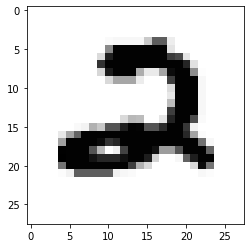

In [3]:
# 取一张图片看看
import matplotlib.pyplot as plt
one_img = test_data.iloc[0,:].values.reshape(28,28)
plt.imshow(one_img, cmap="Greys")

# 建模
+ __加载数据__
+ __定义网络__


In [4]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [6]:
# reshape函数
class ReshapeTransform:
    def __init__(self, new_size, minmax=None):
        self.new_size = new_size
        self.minmax = minmax
    def __call__(self, img):
      if self.minmax:
        img = img/self.minmax # 这里需要缩放到0-1，不然transforms.Normalize会报错
      img = torch.from_numpy(img)
      return torch.reshape(img, self.new_size)



In [8]:
# Dataset类，配合DataLoader使用
class myDataset(Dataset):
  def __init__(self, path, transform=None, is_train=True, seed=777):
    """
    :param path:      文件路径
    :param transform: 数据预处理
    :param train:     是否是训练集
    """
    self.data = pd.read_csv(path) # 读取数据
    # 一般来说训练集会分为训练集和验证集，这里拆分比例为8: 2
    if is_train: 
      self.data, _ = train_test_split(self.data, train_size=0.8, random_state=seed)
    else:
      _, self.data = train_test_split(self.data, train_size=0.8, random_state=seed)
    self.transform = transform  # 数据转化器
    self.is_train = is_train
  def __len__(self):
    # 返回data长度
    return len(self.data)
  def __getitem__(self, idx):
    # 根据index返回一行
    data, lab = self.data.iloc[idx, 1:].values, self.data.iloc[idx, 0]
    if self.transform:
      data = self.transform(data)
    return data, lab


In [9]:
# 预处理Pipeline
transform = transforms.Compose([
    ReshapeTransform((-1,28,28), 255),  # 一维向量变为28*28图片并且缩放(0-255)到0-1
    transforms.Normalize((0.1307,), (0.3081,)) ])# 均值方差标准化, (0.1307,), (0.3081,)是一个经验值不必纠结

# 加载训练集
train_data = myDataset('/Users/wangluya/PycharmProjects/datasets/digit_recognizer/train.csv', transform, True)
train = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
vail_data = myDataset('/Users/wangluya/PycharmProjects/datasets/digit_recognizer/train.csv', transform, False)
vail = DataLoader(vail_data, batch_size=64, shuffle=True, num_workers=4)

# 加载测试集
test_data = pd.read_csv('/Users/wangluya/PycharmProjects/datasets/digit_recognizer/test.csv')
test_data = transform(test_data.values)


In [12]:
print(train_data[0])

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -

+ __定义网络__


In [13]:
# 为了简单起见，这里定义一个两层卷积，两层全连接的网络
# 初始化权重
def _weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
# 建立网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.drop2d = nn.Dropout2d(p=0.2)
        self.linr1 = nn.Linear(20*5*5, 32)
        self.linr2 = nn.Linear(32, 10)
        self.apply(_weight_init) # 初始化权重
    # 正向传播 
    def forward(self, x):
        x = F.relu(self.drop2d(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.drop2d(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 20*5*5) # 卷积接全连接需要计算好卷积输出维度，将卷积输出结果平铺开
        x = self.linr1(x)
        x = F.dropout(x,p=0.5)
        x = self.linr2(x)
        return x
net = Net()

+ __定义优化器与损失函数__


In [14]:
# 优化器和损失函数
optimizer = optim.Adam(net.parameters(), lr=0.0005) # 使用Adam作为优化器
criterion = nn.CrossEntropyLoss() # 损失函数为CrossEntropyLoss，CrossEntropyLoss()=log_softmax() + NLLLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.5) # 这里使用StepLR，每十步学习率lr衰减50%

+ __训练网络__

In [25]:
# 转化为GPU(可选)
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# if torch.cuda.is_available():
#   net = net.to(device)
#   criterion = criterion.to(device)
device = 'cpu' 
epochs = 100
loss_history = []
# 训练模型
for epoch in range(epochs):
    print('epoch==',epoch)
    train_loss = []
    val_loss = []
    with torch.set_grad_enabled(True):
        net.train()
        for batch, (data, target) in enumerate(train):
            data = data.to(device).float()
            target = target.to(device)
            optimizer.zero_grad()
            predict = net(data)
            loss = criterion(predict, target)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
    scheduler.step() # 经过一个epoch，步长+1
    with torch.set_grad_enabled(False):
        net.eval() # 网络中有drop层，需要使用eval模式
        for batch, (data, target) in enumerate(vail):
            data = data.to(device).float()
            target = target.to(device)
            predict = net(data)
            loss = criterion(predict, target)
            val_loss.append(loss.item())
    loss_history.append([np.mean(train_loss), np.mean(val_loss)])
    print('epoch:%d train_loss: %.5f val_loss: %.5f' %(epoch+1, np.mean(train_loss), np.mean(val_loss)))

epoch== 0


KeyboardInterrupt: 

In [20]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.7.1
False
